# Hierarchical Bayesian IDM

<img src="../Figs/Hierarchical_B_IDM_PGM.png" width="480">

In [1]:
import arviz as az
import numpy as np
"""
# If pymc3
"""
# import pymc3 as pm
# from theano import tensor as tt
"""
# If pymc4
"""
import pymc as pm
import aesara.tensor as tt

import random
import pickle
import os
import sys
import matplotlib.pyplot as plt

sys.path.append('../')

from data.data_loader import read_training_data
from config import Config
from os import path
from pickle import UnpicklingError

import warnings
warnings.filterwarnings("ignore")

np.random.seed(1116)

In [2]:
def load_training_data(base_path, step, min_traj_lenth, pair_id_list, N):
    tracks = read_training_data(base_path=base_path, min_traj_lenth=min_traj_lenth)
    for pair_id in pair_id_list:
        if pair_id == pair_id_list[0]:
            vt = tracks[pair_id]['vFollReal']
            s = tracks[pair_id]['sReal']
            dv = tracks[pair_id]['dvReal']
            label_v = tracks[pair_id]['vFollReal_next']
            id_idx = N*np.ones_like(label_v, dtype=int)
        else:
            vt = np.concatenate((vt,tracks[pair_id]['vFollReal']))
            s = np.concatenate((s,tracks[pair_id]['sReal']))
            dv = np.concatenate((dv, tracks[pair_id]['dvReal']))
            label_v = np.concatenate((label_v, tracks[pair_id]['vFollReal_next']))
            id_idx = np.concatenate((id_idx, N*np.ones_like(tracks[pair_id]['sReal'], dtype=int)))
        N += 1
    if step!=1:
        vt = vt[::step]
        s = s[::step]
        dv = dv[::step]
        label_v = label_v[::step]
        id_idx = id_idx[::step]
    
    print("Traj length:",min_traj_lenth*Config.dt, ", ID list:", pair_id_list, ", Data size:", label_v.shape)
    return vt, s, dv, label_v, id_idx

def Bayesian_IDM_hierarchical(base_path, step):
    vt, s, dv, label_v, id_idx = load_training_data(base_path, step=step, min_traj_lenth=50 * Config.frame_rate_orignial,
                                                    pair_id_list=Config.car_interactive_pair_list, N=0)

    vt2, s2, dv2, label_v2, id_idx2 = load_training_data(base_path, step=step, min_traj_lenth=50 * Config.frame_rate_orignial,
                                                         pair_id_list=Config.truck_interactive_pair_list,
                                                         N=len(Config.car_interactive_pair_list))
    vt = np.concatenate((vt,vt2))
    s = np.concatenate((s, s2))
    dv = np.concatenate((dv, dv2))
    label_v = np.concatenate((label_v,label_v2))
    id_idx = np.concatenate((id_idx,id_idx2))
    
    print("training size:", label_v.shape)
    print("s size", s.shape)
    ################################################

    dt = Config.dt

    D = 5
    
    N_veh = len(Config.car_interactive_pair_list)+len(Config.truck_interactive_pair_list)
    coords = {
    "veh_id": np.arange(N_veh),
    "obs_id": np.arange(label_v.shape[0]),
    }
    
   
    with pm.Model(coords=coords) as hierarchical_model:
        def IDM_v(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv):
            sn = DSAFE + vt * TSAFE + vt * dv / (2 * tt.sqrt(AMAX * AMIN))
            a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)
            return vt + a * Config.dt
        
        id_idx = pm.ConstantData("id_idx", id_idx, dims="obs_id")
        s_ = pm.ConstantData("s", s, dims="obs_id")
        vt_ = pm.ConstantData("vt", vt, dims="obs_id")
        dv_ = pm.ConstantData("dv", dv, dims="obs_id")
        
        # Hyperpriors for group nodes
        chol, _, _ = pm.LKJCholeskyCov('chol', n=D, eta=2.0, sd_dist=pm.Exponential.dist(100.0, shape=D))
        cov = pm.Deterministic('cov', chol.dot(chol.T))
        vals_raw = pm.Normal('vals_raw',mu=0, sigma=1, shape=(N_veh, D), dims=('veh_id', ...))

        DELTA = 4
        
        log_mu = pm.Normal('log_mu', mu=0, sigma=1, shape=D)
        mu = pm.Deterministic('mu', tt.exp(log_mu))
        
        log_parameters = pm.Deterministic('log_mu_d', log_mu+tt.dot(chol,vals_raw.T).T)
        parameters = pm.Deterministic('mu_d', tt.exp(log_parameters))
        
        print("parameters.shape.eval():", parameters.shape.eval())
        
        s_a = pm.Exponential('s_a', lam=1e4)
        
        # We normalize the IDM parameters according to the recommended parameters.
        v_obs = pm.Normal('obs', mu=IDM_v(33*parameters[id_idx,0], 2*parameters[id_idx,1], 1.6*parameters[id_idx,2],
                                          1.5*parameters[id_idx,3], 1.67*parameters[id_idx,4],  DELTA,
                                          s_, vt_, dv_), sigma=s_a*dt, observed=label_v, dims="obs_id")

        tr = pm.sample(2500, tune=5000, random_seed=37, init='jitter+adapt_diag_grad', chains=2,
                       cores=14, discard_tuned_samples=True, return_inferencedata=True, target_accept=0.9)
        
    return tr, hierarchical_model

In [3]:
base_path = '../data/highD/'
step = 2
tr, model = Bayesian_IDM_hierarchical(base_path, step)

Traj length: 250.0 , ID list: [14, 35, 23, 25, 36, 38, 60, 90, 228, 232] , Data size: (1625,)
Traj length: 250.0 , ID list: [3, 4, 18, 52, 81, 144, 153, 162, 5, 241] , Data size: (1567,)
training size: (3192,)
s size (3192,)
parameters.shape.eval(): [20  5]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (2 chains in 14 jobs)
NUTS: [chol, vals_raw, log_mu, s_a]


Sampling 2 chains for 5_000 tune and 2_500 draw iterations (10_000 + 5_000 draws total) took 987 seconds.


In [3]:
# Save the trace in the `cache' folder
base_path = '../data/highD/'
cache = "../PGM_highD/cache/Bayesian_IDM_hierarchical.pkl"
if path.exists(cache):
    try:
        fp = open(cache, 'rb')
        tr = pickle.load(fp)
        fp.close()
        print("Load trace", cache, ": done!")
    except UnpicklingError:
        os.remove(cache)
        print('Removed broken cache:', cache)
else:
    output_file = open(cache, 'wb')
    pickle.dump(tr, output_file)
    print("Generated and Saved", output_file, ": done!")

Load trace ../PGM_highD/cache/Bayesian_IDM_hierarchical.pkl : done!


In [4]:
tr.posterior.s_a.mean(axis=0).mean(axis=0)

<xarray.DataArray 's_a' ()>
array(0.21811429)

In [5]:
az.summary(tr, var_names=["mu", "log_mu"]) # index 0-5 are: VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA
# six IDM parameters for the population driver

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],0.606,0.049,0.520,0.698,0.001,0.001,2960.0,3617.0,1.0
mu[1],1.884,0.096,1.708,2.071,0.002,0.001,2837.0,2910.0,1.0
mu[2],0.602,0.053,0.508,0.706,0.001,0.001,1932.0,2355.0,1.0
mu[3],0.699,0.049,0.610,0.794,0.001,0.000,5106.0,3866.0,1.0
mu[4],0.903,0.104,0.703,1.089,0.002,0.001,4777.0,3614.0,1.0
log_mu[0],-0.505,0.079,-0.649,-0.354,0.001,0.001,2960.0,3617.0,1.0
log_mu[1],0.632,0.051,0.535,0.728,0.001,0.001,2837.0,2910.0,1.0
log_mu[2],-0.511,0.088,-0.678,-0.349,0.002,0.001,1932.0,2355.0,1.0
log_mu[3],-0.360,0.070,-0.492,-0.229,0.001,0.001,5106.0,3866.0,1.0
log_mu[4],-0.108,0.115,-0.337,0.098,0.002,0.001,4777.0,3614.0,1.0


In [6]:
az.summary(tr, var_names=["mu_d", "log_mu"],coords={"mu_d_dim_0": [0,10]}) # index 0-4 are: VMAX, DSAFE, TSAFE, AMAX, AMIN
# IDM parameters for the population driver

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"mu_d[0, 0]",0.894,0.306,0.437,1.452,0.006,0.004,2615.0,3660.0,1.0
"mu_d[0, 1]",1.645,0.205,1.262,2.035,0.003,0.002,4840.0,3963.0,1.0
"mu_d[0, 2]",1.759,0.092,1.585,1.929,0.001,0.001,4553.0,4271.0,1.0
"mu_d[0, 3]",0.472,0.050,0.381,0.567,0.001,0.000,5070.0,4155.0,1.0
"mu_d[0, 4]",1.031,0.143,0.770,1.299,0.002,0.001,4850.0,4280.0,1.0
"mu_d[10, 0]",0.957,0.248,0.567,1.400,0.004,0.003,4430.0,4341.0,1.0
"mu_d[10, 1]",1.364,0.217,0.984,1.801,0.003,0.002,5263.0,4188.0,1.0
"mu_d[10, 2]",1.056,0.088,0.891,1.219,0.001,0.001,5404.0,4476.0,1.0
"mu_d[10, 3]",0.389,0.058,0.281,0.495,0.001,0.001,5172.0,4385.0,1.0
"mu_d[10, 4]",0.704,0.095,0.532,0.879,0.001,0.001,5364.0,4192.0,1.0


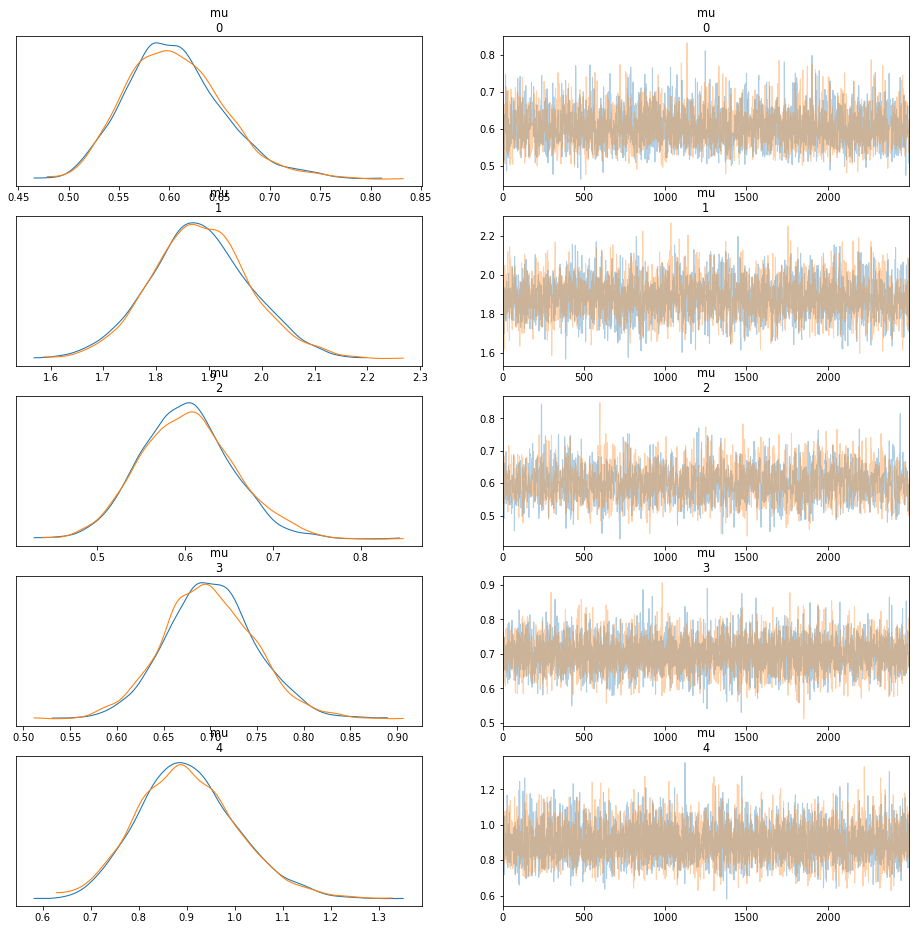

In [7]:
import arviz as az

_ = az.plot_trace(tr, var_names=["mu"], figsize=((16, 16)),compact=False)

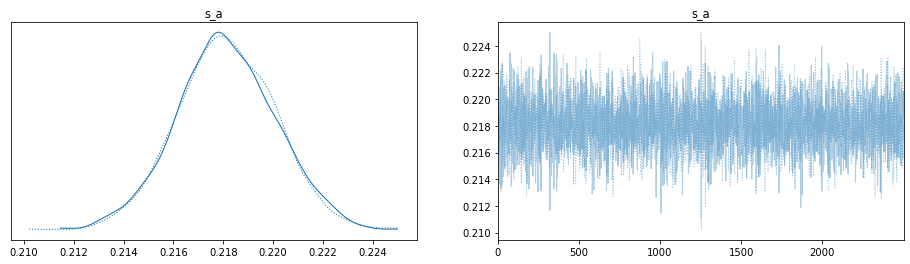

In [8]:
import arviz as az

_ = az.plot_trace(tr, var_names=["s_a"], figsize=((16, 4)))

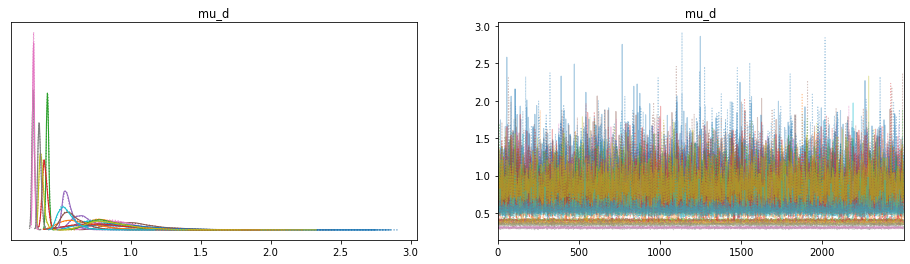

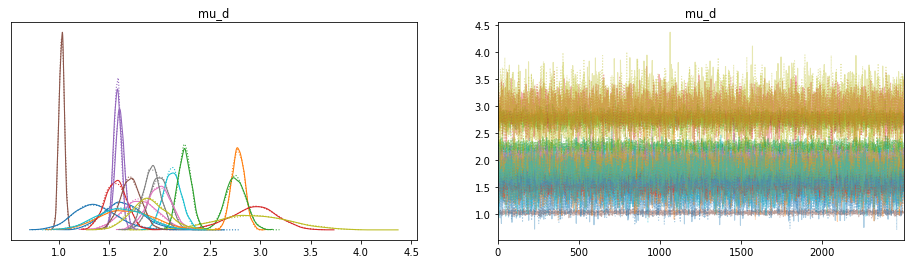

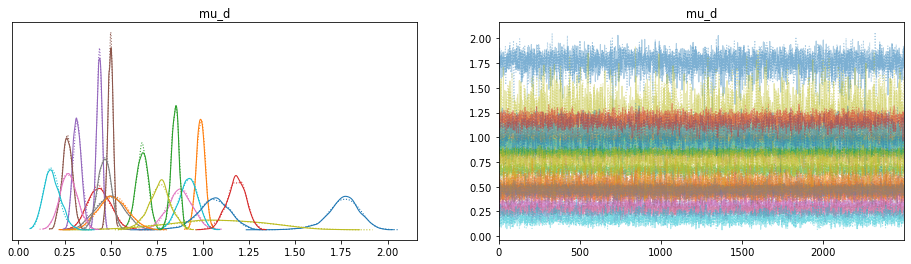

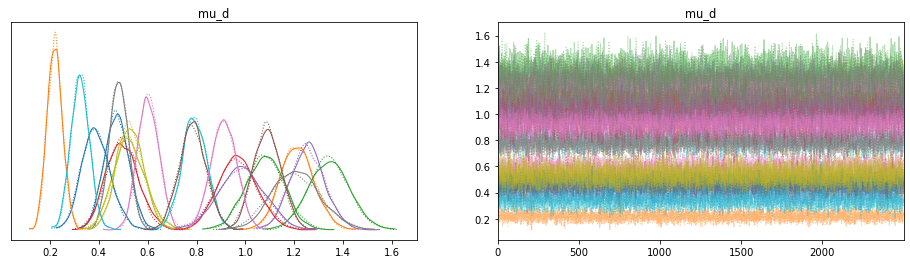

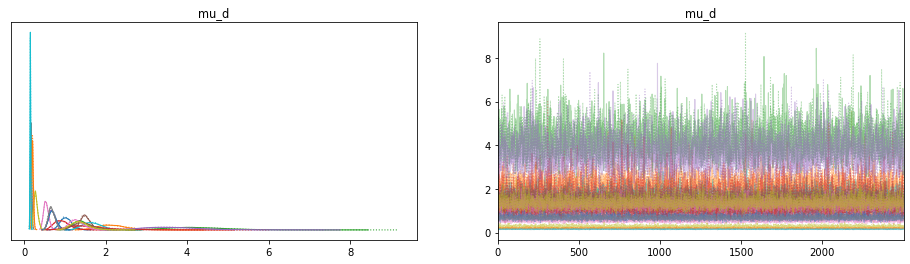

In [9]:
import arviz as az

_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":0}, figsize=((16, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":1}, figsize=((16, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":2}, figsize=((16, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":3}, figsize=((16, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":4}, figsize=((16, 4)),compact=True)

In [10]:
tr.posterior['mu_d'] = tr.posterior.mu_d[:,:,:,:] * [33, 2, 1.6, 1.5, 1.67]

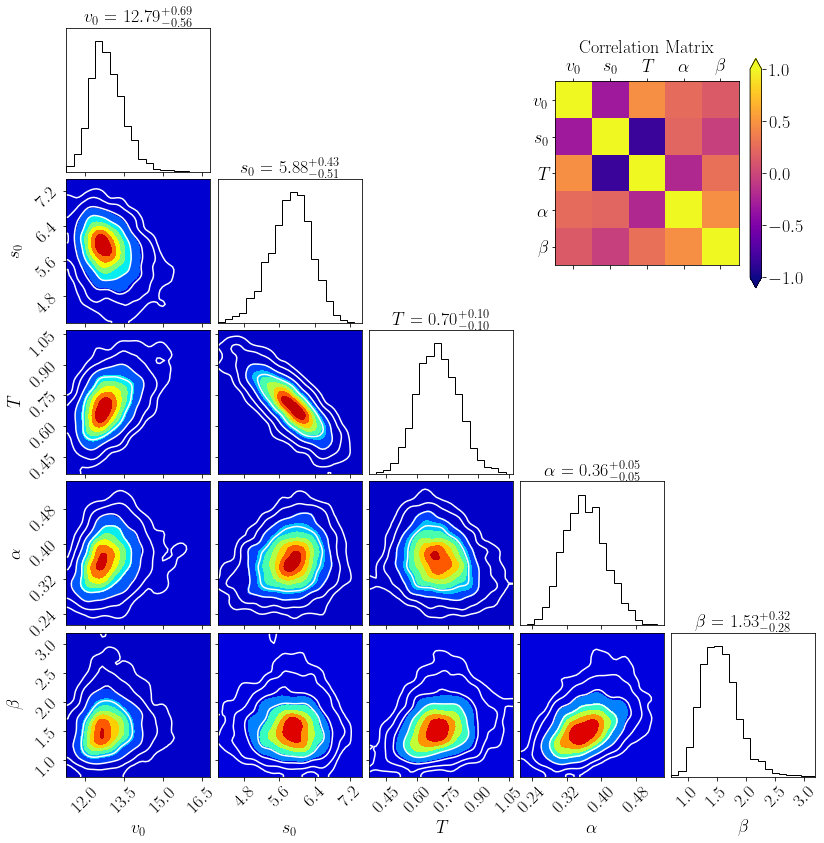

In [11]:
import corner

import matplotlib

label_list = [r'$v_0$',r'$s_0$', r'$T$', r'$\alpha$', r'$\beta$']
fontsize = 18
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "Times New Roman"
matplotlib.rcParams['font.size'] = fontsize
matplotlib.rcParams['font.family'] = 'Times New Roman'

driver_id = 3

figure_d = corner.corner(
    tr,
    var_names=["mu_d"], coords={"mu_d_dim_0":driver_id,"chain":[0]},
    smooth=1.8,
    color = 'k',
    plot_contours=True,
    plot_density=False,
    plot_datapoints = False,
    bins = 20,
    show_titles=True,
    labels=label_list,
    reverse=False,
)

ax_new = figure_d.add_axes([.66, .66, .27, .27])
cov = np.cov(tr.posterior.mu_d[0,:,driver_id,:], rowvar=False)
Dinv = np.diag(1 / np.sqrt(np.diag(cov)))
corr = Dinv @ cov @ Dinv
kwargs = {'cmap':'plasma','interpolation':'nearest', 'vmin':-1}
corr_show = ax_new.matshow(corr, **kwargs)
c_bar = figure_d.colorbar(corr_show, ax=ax_new, extend='both')
ax_new.set_xticklabels(['']+label_list)
ax_new.set_yticklabels(['']+label_list)
ax_new.set_title('Correlation Matrix')
for item in ([ax_new.title, ax_new.xaxis.label, ax_new.yaxis.label] +
             ax_new.get_xticklabels() + ax_new.get_yticklabels()):
    item.set_fontsize(fontsize)

# figure_d.savefig('../Figs/B_IDM_hierarchical_driver{:}.pdf'.format(driver_id), dpi=300)

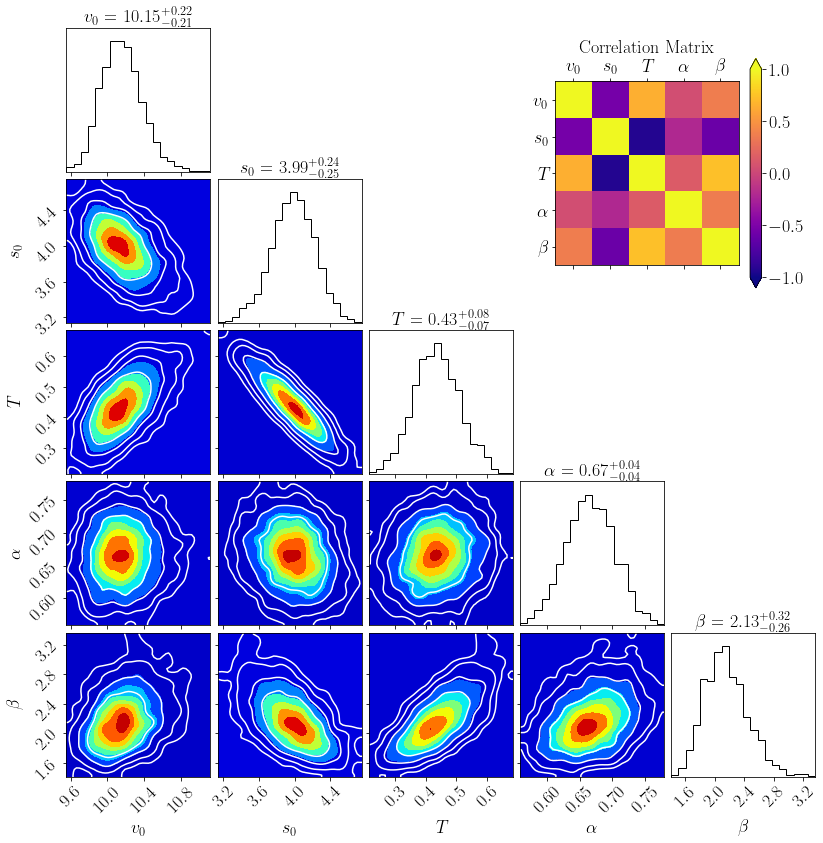

In [12]:
import corner

driver_id = 16

import matplotlib

label_list = [r'$v_0$',r'$s_0$', r'$T$', r'$\alpha$', r'$\beta$']
fontsize = 18
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

figure_d = corner.corner(
    tr,
    var_names=["mu_d"], coords={"mu_d_dim_0":driver_id,"chain":[0]},
    smooth=1.8,
    color = 'k',
    plot_contours=True,
    plot_density=False,
    plot_datapoints = False,
    bins = 20,
    show_titles=True,
    labels=label_list,
    reverse=False,
)

ax_new = figure_d.add_axes([.66, .66, .27, .27])
cov = np.cov(tr.posterior.mu_d[0,:,driver_id,:], rowvar=False)
Dinv = np.diag(1 / np.sqrt(np.diag(cov)))
corr = Dinv @ cov @ Dinv
kwargs = {'cmap':'plasma','interpolation':'nearest', 'vmin':-1}
corr_show = ax_new.matshow(corr, **kwargs)
c_bar = figure_d.colorbar(corr_show, ax=ax_new, extend='both')
ax_new.set_xticklabels(['']+label_list)
ax_new.set_yticklabels(['']+label_list)
ax_new.set_title('Correlation Matrix')
for item in ([ax_new.title, ax_new.xaxis.label, ax_new.yaxis.label] +
             ax_new.get_xticklabels() + ax_new.get_yticklabels()):
    item.set_fontsize(fontsize)

# figure_d.savefig('../Figs/B_IDM_hierarchical_driver{:}.pdf'.format(driver_id), dpi=300)